In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
final_dataframe = pd.read_csv('./data/sells_time_series.csv', index_col=0)
final_dataframe.index = pd.to_datetime(final_dataframe.index)


In [3]:
sells = final_dataframe['lampa']



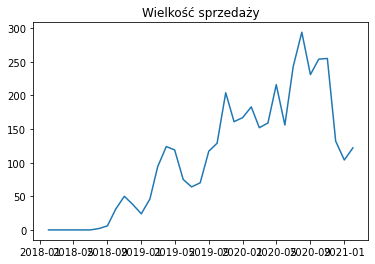

In [4]:
plt.plot(sells)
plt.title('Wielkość sprzedaży')
plt.show()

In [5]:
sells_decomposed = seasonal_decompose(sells, model='additive', period = 12, extrapolate_trend=6)


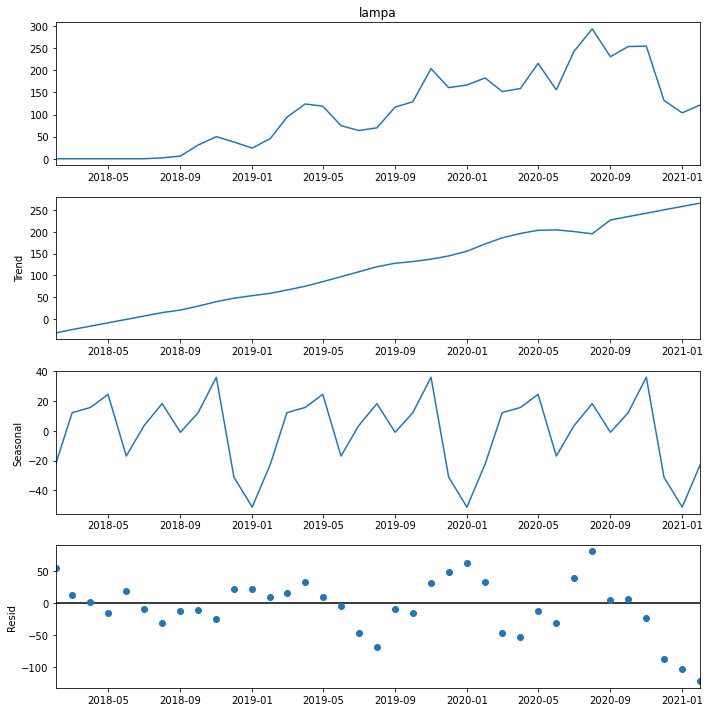

In [6]:
plt.rcParams.update({'figure.figsize': (10,10)})
sells_decomposed.plot()
plt.show()

# Obliczanie miary sezonowości
na podstawie:
https://otexts.com/fpp2/seasonal-strength.html

W skrócie polega ona na tym, że jeżeli sezonowość występuje to wtedy
wariancja sezonowości+residual będzie dużo większa niż samego residual.
Ostatecznie jeżeli odejmę od 1 stosunek tych dwóch powyższych wariancji,
to wtedy duże wartości będą świadczyć o silnej sezonowości, a małe o niskiej:

max(0, 1 - resid_var/seas_and_resid_var)

Poniżej przykład:

In [7]:
resid_var = np.var(sells_decomposed.resid)
seas_and_resid_var = np.var(sells_decomposed.resid+sells_decomposed.seasonal)

seanality_strength = max(0, 1 - resid_var/seas_and_resid_var)

print(seanality_strength)

0.2385846512810882


In [8]:
resid_var = np.var(sells_decomposed.resid)
trend_and_resid_var = np.var(sells_decomposed.trend+sells_decomposed.seasonal)

trend_strength = max(0, 1 - resid_var/trend_and_resid_var)

print(trend_strength)

0.768911873003449


Powyższe wyniki pokazują że na wyniki sprzedaży danego produktu sezonowość wpływa słabo, ale trend wpływa mocno

## Analiza wszystkich produktów i wybranie tych najbardziej sezonowych

In [9]:
def calc_seasonality_strength(time_series, model='additive', period = 12, extrapolate_trend=6):
    series_decomposed = seasonal_decompose(
        time_series, model=model, period = period, extrapolate_trend=extrapolate_trend
    )

    resid_var = np.var(series_decomposed.resid)
    seas_and_resid_var = np.var(series_decomposed.resid+series_decomposed.seasonal)
    trend_and_resid_var = np.var(series_decomposed.resid+series_decomposed.trend)

    seanality_strength = max(0, 1 - resid_var/seas_and_resid_var)
    trend_strength = max(0, 1 - resid_var/trend_and_resid_var)

    return trend_strength, seanality_strength

In [10]:
results = pd.DataFrame(index=final_dataframe.columns)
results['seasonal'] = 0.0  # placeholder
results['trend'] = 0.0  # placeholder

for product in tqdm(final_dataframe.columns):

    trend_strength, seanality_strength = calc_seasonality_strength(final_dataframe[product])
    results['seasonal'][product] = seanality_strength
    results['trend'][product] = trend_strength

100%|██████████| 5569/5569 [00:12<00:00, 443.63it/s]


In [11]:
# TOP 10 sezonowych produktów
results.sort_values(by='seasonal', ascending=False).head(10)


,seasonal,trend
strój świętego,0.881225,0.189542
szlafrok unisex,0.757613,0.515521
naciągany pokrowiec,0.740653,0.622857
siatka ogrodzeniowa,0.721494,0.664771
ostrzałka pił,0.718631,0.248381
zestaw wypoczynkowy,0.718409,0.540801
stolik krzesła,0.709425,0.492480
ogrodowy stół,0.708391,0.635025
donica gabionowa,0.701651,0.649427
ławka wokół,0.700390,0.169202


In [12]:
# TOP 10 produktów z najsilniejszym trendem
results.sort_values(by='trend', ascending=False).head(10)

,seasonal,trend
regał na książkiprzegroda,0.403838,0.902506
regał,0.410024,0.899588
samoprzylepne panele,0.405751,0.884119
parawan panelowy,0.375751,0.873820
zegar ścienny,0.306916,0.866098
biurko,0.404238,0.824684
panel ochronny,0.321952,0.822137
kosz na śmieci,0.163065,0.817131
klatka dla,0.604560,0.809499
regał na książki,0.275414,0.806853


In [13]:
sells = final_dataframe['lampa']



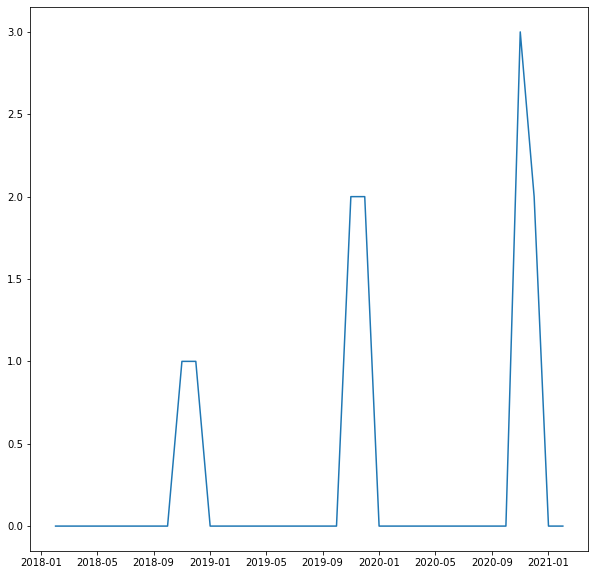

In [14]:
# Rzeczywiście strój mikołaja jest baardzo sezonowy

plt.plot(final_dataframe['strój świętego'])

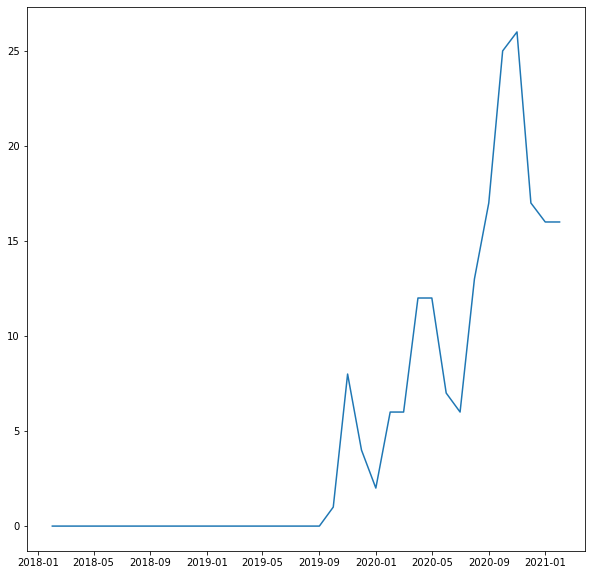

In [15]:
# A regał na książki bardzo silny wzrost
plt.plot(final_dataframe['regał na książkiprzegroda'])
